# LSTM with Sine Waves

## System setup

There are a few system libraries and Python packages required to work with audio. If needed, uncomment and run this cell.

Note that the cell returns an error code whether there's an error or not. This seems to be due to Jupyter's shell command handling. You'll need to read the outputs in the cell to determine whether anything actually went wrong - sorry!

In [80]:
# Run this cell first!
# %%bash
# ./install.sh
# ./buildFastAiAudio.sh

<span style="color:red">**Don't forget to restart your notebook kernel after you've installed these modules!**</span> 

### fastai default setup

In [81]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [82]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [83]:
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataBlockSequence import *
from exp.nb_DataAugmentation import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [84]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

In [85]:
data_folder = datapath4file('sine')

In [86]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/sine/200hz.wav'),
 PosixPath('/home/jupyter/.fastai/data/sine/20hz.wav'),
 PosixPath('/home/jupyter/.fastai/data/sine/1000hz.wav'),
 PosixPath('/home/jupyter/.fastai/data/sine/20000hz.wav'),
 PosixPath('/home/jupyter/.fastai/data/sine/18000hz.wav')]

In [87]:
import glob

In [88]:
wavs = glob.glob(str(data_folder/'**/*.wav'), recursive=True)
wavs = wavs * 100
twenty_percent = int(len(wavs) * 0.2)

In [89]:
train_data = []
valid_data = []
for wav in wavs[:-twenty_percent]:
    train_data.append(AudioSequenceItem.from_file(wav, sample_len=250, stride_len=125, max_seqs=300))
for wav in wavs[-twenty_percent:]:
    valid_data.append(AudioSequenceItem.from_file(wav, sample_len=250, stride_len=125, max_seqs=300))

In [90]:
train_data[:2], valid_data[:2]

([AudioSequenceItem Length: 175 | Shape: torch.Size([250]) | Sample Rate: 44100,
  AudioSequenceItem Length: 175 | Shape: torch.Size([250]) | Sample Rate: 44100],
 [AudioSequenceItem Length: 175 | Shape: torch.Size([250]) | Sample Rate: 44100,
  AudioSequenceItem Length: 175 | Shape: torch.Size([250]) | Sample Rate: 44100])

In [91]:
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

db = AudioSequenceDataBunch.from_df(Path('.'), train_df, valid_df, bs=32);
len(db.train_ds), len(db.valid_ds)

(1600, 400)

In [133]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=100, hidden_size=512):
        super().__init__()
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *xb):
        outputs = []
        hiddens = []
        hidden = None
        out = None
        for x in xb:
            input = x.unsqueeze(0)
            hidden = None
            for i, rnn in enumerate(self.rnns):
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [134]:
lstm = SimpleLSTM(input_size=250); lstm.cuda()
learn = Learner(db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


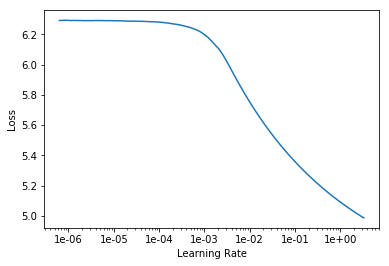

In [135]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.920367,5.185872,00:08
1,4.840798,4.370310,00:08
2,4.523293,4.363056,00:08
3,4.418484,4.360313,00:08
4,4.380760,4.359057,00:08
5,4.366758,4.358553,00:08
6,4.361476,4.358463,00:09


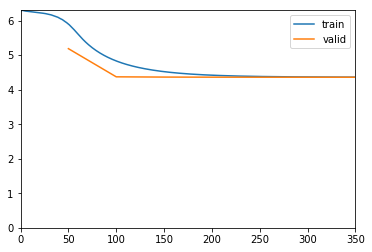

In [116]:
learn.fit_one_cycle(7, max_lr=1e-03)

In [31]:
def get_sub_seq(seq, max_len):
    if len(seq) <= max_len: return seq
    furthest = len(seq) - max_len
    begin = math.floor(furthest * random.uniform(0,1))
    return seq[begin:begin + max_len]

In [32]:
get_sub_seq(list(range(100)), 10)

[82, 83, 84, 85, 86, 87, 88, 89, 90, 91]

In [98]:
def calculate_norm_params(seqs):
    means, devs = [], []
    for seq in seqs:
        seq_mean = seq.spectro.mean()
        seq_std_dev = seq.spectro.std()
        means.append(seq_mean)
        devs.append(seq_std_dev)
    return torch.tensor(means).mean().item(), torch.tensor(devs).mean().item()

In [99]:
# To run this computation again, assign `None` to norm_params
norm_params = (-77.12715148925781, 12.76711654663086)

In [100]:
%%time
# Change sharing strategy so we avoid too many open files error during processing
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')


spectro_train_data = []
spectro_valid_data = []
TEN_MS_AT_16000_SR = 160
spec_params = {
    "spectro": True,
    "to_db_scale": True,
    "ws": TEN_MS_AT_16000_SR,
    "n_mels": 128,
}
for wav in wavs[:-twenty_percent]:
    spectro_train_data.append(AudioSequenceItem.from_file(wav, norm_params=norm_params, **spec_params))
for wav in wavs[-twenty_percent:]:
    spectro_valid_data.append(AudioSequenceItem.from_file(wav, norm_params=norm_params, **spec_params))

CPU times: user 38 s, sys: 288 ms, total: 38.3 s
Wall time: 10.1 s


In [101]:
# calculate_norm_params(spectro_train_data)

In [102]:
spectro_train_df = pd.DataFrame(spectro_train_data)
spectro_valid_df = pd.DataFrame(spectro_valid_data)

In [103]:
spectro_db = AudioSequenceDataBunch.from_df(Path('.'), spectro_train_df, spectro_valid_df, bs=16);
len(spectro_db.train_ds), len(spectro_db.valid_ds)

(1600, 400)

In [104]:
num_features = spectro_db.train_ds.x[0].shape[0]
print('Number of Features:', spectro_db.train_ds.x[0].shape[0])

Number of Features: 128


In [105]:
lstm = SimpleLSTM(input_size=250); lstm.cuda()
learn = Learner(db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


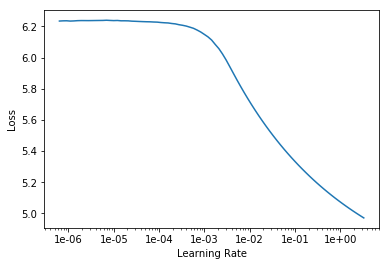

In [44]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.862680,5.172224,00:07
1,4.828220,4.374786,00:07
2,4.522060,4.367537,00:07
3,4.420449,4.363279,00:07
4,4.383136,4.361532,00:08
5,4.369075,4.360780,00:07
6,4.363710,4.360649,00:08


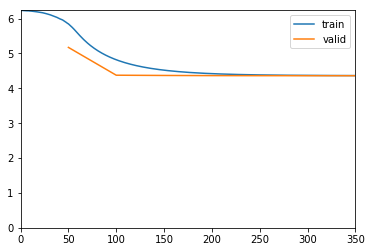

In [45]:
learn.fit_one_cycle(1, max_lr=1e-03)

## Generating Audio

In [27]:
def generate_sound(seed, sound_len=8000):
    frames = torch.tensor(seed.data[0][0])
    val = seed
    for frame in range(0, sound_len):
        label, _, sig = learn.predict(val)
        (sig)
        frames = torch.cat((frames, sig.clone().squeeze(0)))
        val = AudioSequenceItem(AudioData(sig), sample_len=250, stride_len=125, max_seqs=300)
    print('Generated frame length', len(frames))
    return frames

In [28]:
seed = db.valid_ds.x[-100]

In [29]:
seed.data[0][0].shape

torch.Size([250])

In [30]:
generated = generate_sound(seed, sound_len=1000)

/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Generated frame length 512250


In [248]:
torchaudio.save('tmp.wav', generated, 16000)

In [15]:
sig, sr = torchaudio.load('tmp.wav')

In [266]:
generated[0][:-100]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0022, 0.0018, 0.0017])

In [19]:
sig[0][:100]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -3.0518e-05,  3.0518e-05,  9.1553e-05,
        -3.0518e-05, -6.1035e-05, -1.5259e-04, -1.5259e-04, -1.5259e-04,
        -1.8311e-04, -6.1035e-05, -1.5259e-04, -9.1553e-05, -2.7466e-04,
        -2.1362e-04, -9.1553e-05, -1.2207e-04, -1.2207e-04, -2.1362e-04,
        -2.4414e-04, -2.7466e-04, -2.1362e-04, -2.7466e-04, -1.5259e-04,
        -6.1035e-05, -2.4414e-04, -2.7466e-04, -3.0518e-05, -1.5259e-04,
        -1.5259e-04, -1.8311e-04, -9.1553e-05, -6.1035e-05, -9.1553e-05,
        -9.1553e-05, -1.2207e-04, -6.1035e-05, -9.1

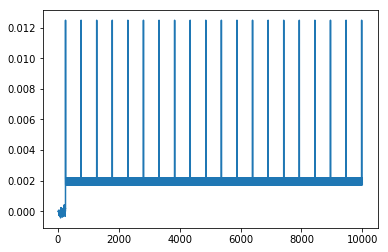

In [25]:
plt.plot(sig[0][:10000])

In [249]:
Audio('tmp.wav', rate=16000)

## LSTM with Spectrogram

Remake databunch with spectrogram:

In [92]:
def get_sub_seq(seq, max_len):
    if len(seq) <= max_len: return seq
    furthest = len(seq) - max_len
    begin = math.floor(furthest * random.uniform(0,1))
    return seq[begin:begin + max_len]

In [93]:
get_sub_seq(list(range(100)), 10)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [94]:
def calculate_norm_params(seqs):
    means, devs = [], []
    for seq in seqs:
        seq_mean = seq.spectro.mean()
        seq_std_dev = seq.spectro.std()
        means.append(seq_mean)
        devs.append(seq_std_dev)
    return torch.tensor(means).mean().item(), torch.tensor(devs).mean().item()

In [95]:
# To run this computation again, assign `None` to norm_params
norm_params = (-76.72248840332031, 10.353596687316895)

In [96]:
%%time
# Change sharing strategy so we avoid too many open files error during processing
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')


spectro_train_data = []
spectro_valid_data = []
TEN_MS_AT_16000_SR = 160
spec_params = {
    "spectro": True,
    "to_db_scale": True,
    "ws": TEN_MS_AT_16000_SR,
    "n_mels": 128,
}
for wav in wavs[:-twenty_percent]:
    spectro_train_data.append(AudioSequenceItem.from_file(wav, norm_params=norm_params, **spec_params))
for wav in wavs[-twenty_percent:]:
    spectro_valid_data.append(AudioSequenceItem.from_file(wav, norm_params=norm_params, **spec_params))

CPU times: user 4min 10s, sys: 1.9 s, total: 4min 12s
Wall time: 1min 6s


In [98]:
# calculate_norm_params(spectro_train_data)

In [97]:
spectro_train_df = pd.DataFrame(spectro_train_data)
spectro_valid_df = pd.DataFrame(spectro_valid_data)

In [99]:
spectro_db = AudioSequenceDataBunch.from_df(Path('.'), spectro_train_df, spectro_valid_df, bs=16);
len(spectro_db.train_ds), len(spectro_db.valid_ds)

(3074, 768)

In [100]:
num_features = spectro_db.train_ds.x[0].shape[0]
print('Number of Features:', spectro_db.train_ds.x[0].shape[0])

Number of Features: 128


In [101]:
class SimpleLSTM(nn.Module):
    def __init__(self,
                 input_size=128,
                 hidden_size=512,
                 max_seq_len=50):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *orig_seq):
        outputs = []
        hiddens = []
        hidden = None
        sub_seq = get_sub_seq(orig_seq, self.max_seq_len)
        for seq in sub_seq:
            input = seq.unsqueeze(0)
            hidden = None
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [49]:
lstm = SimpleLSTM(input_size=num_features, max_seq_len=250); lstm.cuda()
learn = Learner(spectro_db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


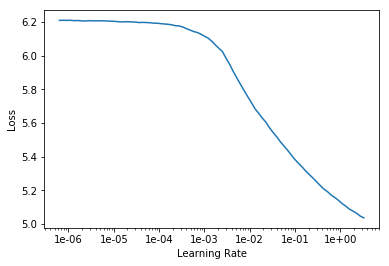

In [50]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,4.947537,4.573778,00:51
1,4.474853,4.404509,00:49
2,4.365281,4.356997,00:51
3,4.311965,4.300733,00:53
4,4.298953,4.297258,00:48
5,4.295428,4.296410,00:53
6,4.293892,4.293447,00:47
7,4.292353,4.293262,00:51
8,4.290353,4.289567,00:52
9,4.289752,4.288784,00:48


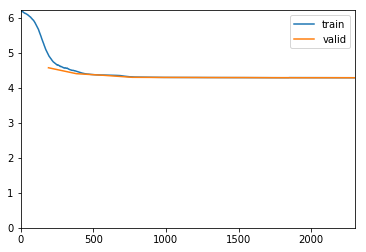

In [51]:
learn.fit_one_cycle(12, max_lr=1e-03)

In [53]:
class SimplerLSTM(nn.Module):
    def __init__(self,
                 input_size=128,
                 hidden_size=512,
                 max_seq_len=50):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        ])
        
    def forward(self, *orig_seq):
        outputs = []
        hiddens = []
        hidden = None
        sub_seq = get_sub_seq(orig_seq, self.max_seq_len)
        for seq in sub_seq:
            input = seq.unsqueeze(0)
            hidden = None
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [56]:
lstm = SimplerLSTM(input_size=num_features, max_seq_len=250); lstm.cuda()
simpler_learn = Learner(spectro_db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


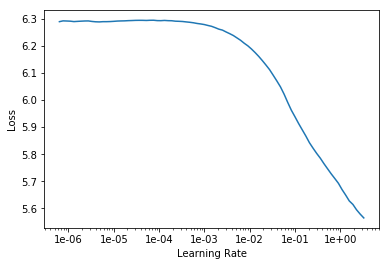

In [57]:
lr_find(simpler_learn)
simpler_learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.035761,4.910454,00:30
1,4.842904,4.849673,00:34
2,4.831969,4.812262,00:31
3,4.757701,4.755404,00:33
4,4.739578,4.737401,00:34
5,4.735046,4.734887,00:29


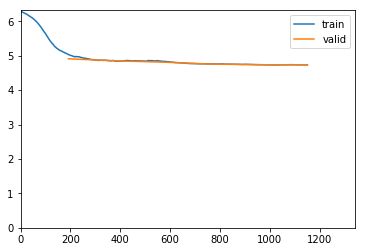

RuntimeError: Traceback (most recent call last):
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/jupyter/fastai/fastai/torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 207, in default_collate
    storage = batch[0].storage()._new_shared(numel)
  File "/opt/anaconda3/envs/fastai-audio/lib/python3.7/site-packages/torch/storage.py", line 120, in _new_shared
    return cls._new_using_filename(size)
RuntimeError: unable to open shared memory object </torch_2954_1122565635> in read-write mode


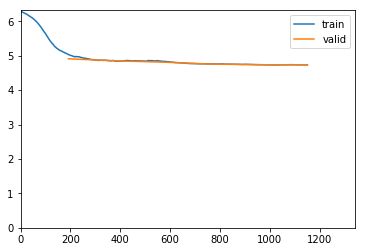

In [58]:
simpler_learn.fit_one_cycle(7, max_lr=1e-02)

In [59]:
class ComplexLSTM(nn.Module):
    def __init__(self,
                 input_size=128,
                 hidden_size=512,
                 max_seq_len=50):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *orig_seq):
        outputs = []
        hiddens = []
        hidden = None
        sub_seq = get_sub_seq(orig_seq, self.max_seq_len)
        for seq in sub_seq:
            input = seq.unsqueeze(0)
            hidden = None
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [60]:
lstm = ComplexLSTM(input_size=num_features, max_seq_len=250); lstm.cuda()
complex_learn = Learner(spectro_db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


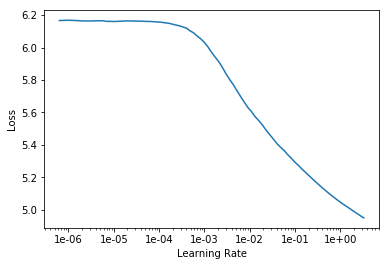

In [61]:
lr_find(complex_learn)
complex_learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,4.604365,4.439401,01:17
1,4.351196,4.348434,01:18
2,4.345378,4.344112,01:21
3,4.348901,4.343926,01:22


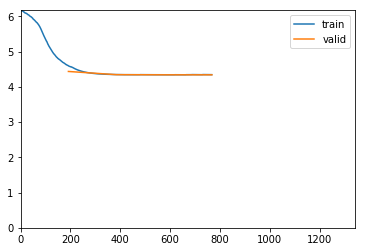

KeyboardInterrupt: 

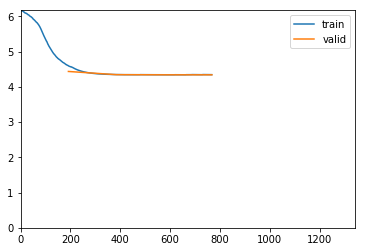

In [62]:
complex_learn.fit_one_cycle(7, max_lr=1e-03)

## With larger inner layers:

In [72]:
class SimpleLSTM(nn.Module):
    def __init__(self,
                 input_size=128,
                 hidden_size=1150,
                 max_seq_len=50):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *orig_seq):
        outputs = []
        hiddens = []
        hidden = None
        sub_seq = get_sub_seq(orig_seq, self.max_seq_len)
        for seq in sub_seq:
            input = seq.unsqueeze(0)
            hidden = None
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [73]:
lstm = SimpleLSTM(input_size=num_features, max_seq_len=250); lstm.cuda()
learn = Learner(spectro_db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


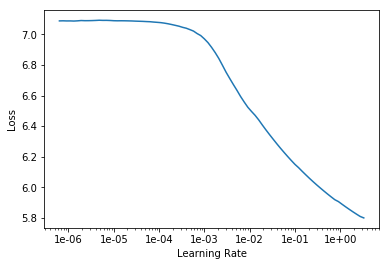

In [74]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.284611,5.182364,01:34
1,5.172134,5.159623,01:34
2,5.156323,5.155673,01:34


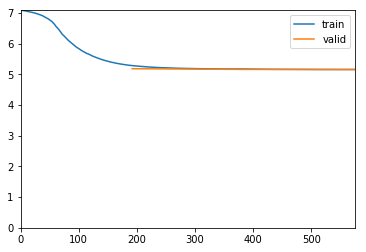

In [75]:
learn.fit_one_cycle(3, max_lr=1e-03)

## Fin.